In [3]:
# Analysis script that tests and compares the filtering algorithms used in PyBirales

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import analysis
from analysis import sns
import os

In [5]:
ROOT = "/media/denis/backup/birales"
DAT_FILE = "2019/2019_02_11/norad_19120/norad_19120_raw.dat"
FILEPATH = os.path.join(ROOT, DAT_FILE)
SAVE_FIGURES = False
NANTS = 32
NSAMPLES = 262144
SKIP = 1
NCHUNKS = 2

In [6]:
rawdata_file = open(FILEPATH, 'rb')
rawdata_file.seek(NSAMPLES * NANTS * 8 * SKIP)
NBLOBS = 1
data = rawdata_file.read(NSAMPLES * NANTS * 8 * NCHUNKS)
rawdata_file.close()

data = np.frombuffer(data, np.complex64)
data = data.reshape((1, 1, NSAMPLES*NCHUNKS, NANTS))

# Reduce the data to an Samples by Antenna id array
data = data[0,0,:,:]

print "Start reading file at {}".format(NSAMPLES * NANTS * 8 * SKIP)
print "Raw data: {} samples, {} antennas".format(data.shape[0], data.shape[1])



Start reading file at 67108864
Raw data: 524288 samples, 32 antennas


Noise mean: -7.58711848903e-07, noise std: 0.00173607422039


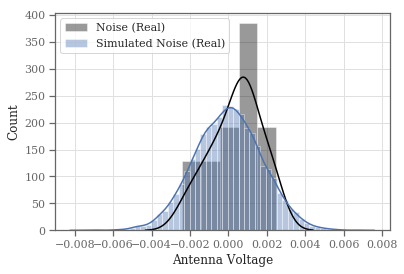

In [51]:
# Plot the noise distribution for 1 antenna
SAMPLES_TO_PLOT = 10000

# Plot the empirical and simulated noise distribution (real)
ax2 = sns.distplot(data.real.flatten()[:SAMPLES_TO_PLOT], color='black', label='Noise (Real)')
noise_mean = np.mean(data.real)
noise_std = np.std(data.real)
noise_sim = np.random.normal(noise_mean, noise_std, SAMPLES_TO_PLOT)
ax2 = sns.distplot(noise_sim, label='Simulated Noise (Real)')
ax2.set(xlabel='Antenna Voltage', ylabel='Count')   
ax2.legend()

print "Real Noise mean voltage: {}, noise std: {}".format(noise_mean, noise_std)


Imag Noise mean voltage: -4.57960027234e-07, noise voltage std: 0.00173576816451


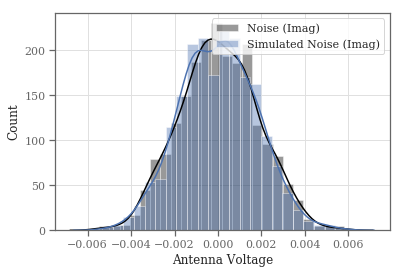

In [58]:
# Plot the empirical and simulated noise distribution (imag)
ax3 = sns.distplot(data.imag.flatten()[:SAMPLES_TO_PLOT], color='black', label='Noise (Imag)')
noise_mean = np.mean(data.imag)
noise_std = np.std(data.imag)
noise_sim = np.random.normal(noise_mean, noise_std, SAMPLES_TO_PLOT)
ax3 = sns.distplot(noise_sim, label='Simulated Noise (Imag)')
ax3.set(xlabel='Antenna Voltage', ylabel='Count')   
ax3.legend()

print "Imag Noise mean voltage: {}, noise voltage std: {}".format(noise_mean, noise_std)

Text(0.5,1,'Antenna Voltages in Antenna 15')

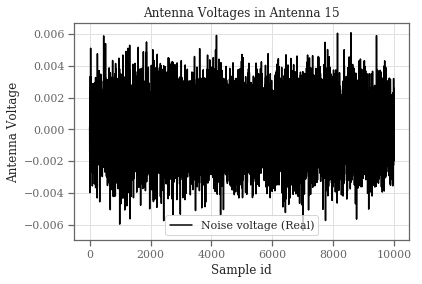

In [75]:
# Plot the noise power against time for multiple antennas

# Plot the empirical and simulated noise distribution (imag)
SAMPLES_TO_PLOT = 10000
ANTENNA_ID = 15
voltages = data.real[:SAMPLES_TO_PLOT, ANTENNA_ID]
time = np.arange(0,len(voltages),1)


ax4 = sns.lineplot(y=voltages, x=time, color='black', label='Noise voltage (Real)')
ax4.set(xlabel='Sample id', ylabel='Antenna Voltage')   
ax4.legend()
plt.title("Antenna voltages in Antenna {}".format(ANTENNA_ID))

Antenna 15: Mean Noise power: 6.05137802268e-06, noise power std: 6.0668835431e-06
Threshold set at 3.0134262942738133e-05


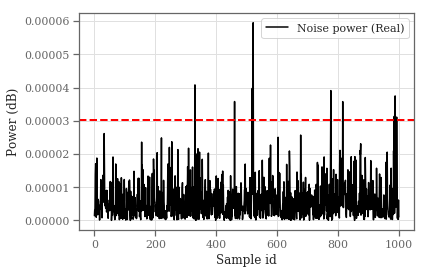

In [76]:
SNR = 5
SAMPLES_TO_PLOT = 1000
ANTENNA_ID = 15
power = np.power(np.abs(data[:SAMPLES_TO_PLOT,ANTENNA_ID]), 2.0)
time = np.arange(0,len(power),1)

ax5 = sns.lineplot(y=power, x=time, color='black', label='Noise power')
ax5.set(xlabel='Sample id', ylabel='Power (dB)')   
ax5.legend()

print "Antenna {}: Mean Noise power: {}, noise power std: {}".format(ANTENNA_ID, np.mean(power), np.std(noise_power))

threshold = np.mean(noise_power) * SNR
ax5.axhline(y=threshold, xmin=0, xmax=1, linewidth=2,linestyle='dashed', color='red')

print "Threshold set at", threshold

-0.8072561946939201 0.9966218482256497
-0.00032545932071808957


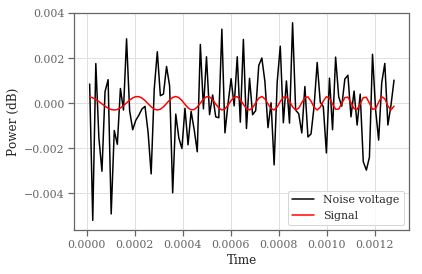

In [209]:
from scipy.signal import chirp,gausspulse
SAMPLES_TO_PLOT = 100
SNR = 200
step = 1. / 78125

t0 = 1
t1 = int(5 / step)
ds_span = 3000
transmitter_frequency = 410.085 * 1e6
f0 = transmitter_frequency - ds_span
ts = np.arange(start=step * t0, stop=step * t1, step=step)

voltage = np.random.normal(0, noise_std, len(ts))
amplitude = SNR * np.mean(voltage)
e = gausspulse(ts, fc=1000 )
signal = 0.0003*chirp(t=ts, f0=f0, f1=f0*1.1, t1=step * t1)

print np.min(e), np.max(e)
ax6 = sns.lineplot(y=voltage[:SAMPLES_TO_PLOT], x=ts[:SAMPLES_TO_PLOT], color='black', label='Noise voltage')
ax6 = sns.lineplot(y=signal[:SAMPLES_TO_PLOT], x=ts[:SAMPLES_TO_PLOT], color='red', label='Signal')
# ax6 = sns.lineplot(y=abs(signal[:SAMPLES_TO_PLOT]+voltage[:SAMPLES_TO_PLOT]), x=ts[:SAMPLES_TO_PLOT],linestyle='dashed', color='blue', label='N + S')
# ax6 = sns.lineplot(y=abs(e[:SAMPLES_TO_PLOT]), x=ts[:SAMPLES_TO_PLOT], color='green', label='Envelope')

print amplitude

ax6.set(xlabel='Time', ylabel='Power (dB)')   
ax6.legend()

1.2499967996260681e-05
1.2499967996260683e-06
Mean Noise power -64.52547701514226
Mean Signal + noise power -52.041363006282715
SNR 12.484114008859542


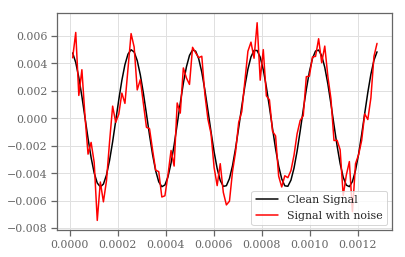

In [249]:
# Set a target SNR
target_snr_db = 10
# Calculate signal power and convert to dB 
x_volts = chirp(t=ts, f0=f0, f1=f0*1.1, t1=step * t1)

x_volts = 0.005*chirp(t=ts, f0=f0, f1=f0, t1=step * t1)
x_watts = x_volts ** 2

sig_avg_watts = np.mean(x_watts)
print sig_avg_watts
sig_avg_db = 10 * np.log10(sig_avg_watts)
# Calculate noise according to [2] then convert to watts
noise_avg_db = sig_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)
# Generate an sample of white noise
print noise_avg_watts
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
# Noise up the original signal
y_volts = x_volts + noise_volts

ax7 = sns.lineplot(y=x_volts[:SAMPLES_TO_PLOT], x=ts[:SAMPLES_TO_PLOT], color='black', label='Clean Signal')
ax7 = sns.lineplot(y=y_volts[:SAMPLES_TO_PLOT], x=ts[:SAMPLES_TO_PLOT], color='red', label='Signal with noise')

m_noise =  np.mean(10*np.log10(np.power(noise_volts, 2)))
m_signal =  np.mean(10*np.log10(np.power(x_volts, 2)))
m_signal_w_noise =  np.mean(10*np.log10(np.power(y_volts, 2)))

print 'Mean Noise power', m_noise
print 'Mean Signal + noise power', m_signal_w_noise
print 'SNR', m_signal_w_noise - m_noise



[Text(0,0.5,'Antenna Voltage'), Text(0.5,0,'Time Sample')]

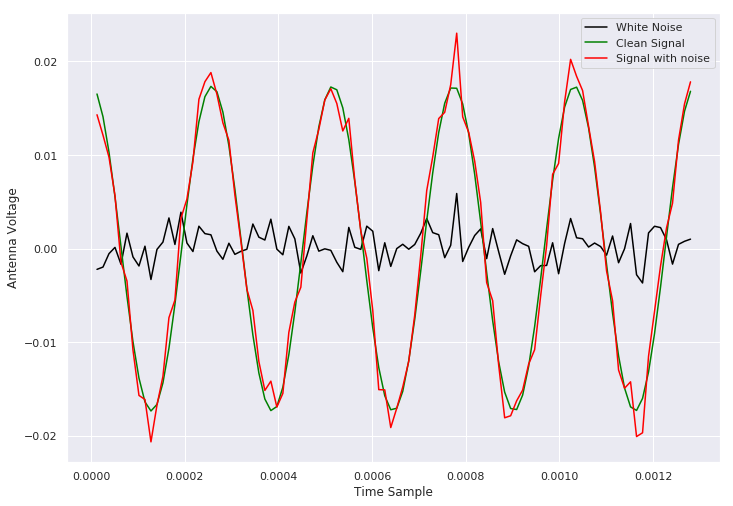

In [268]:
# Change the amplitude of the chirp based on the SNR ratio.
# TODO - not sure how the noise_std experimental is used as a mean for the noise average

TARGET_SNR = 20
NOISE_STD = 0.00173607422039 # experimentally derived standard deviation of the noise

noise_avg_watts = NOISE_STD**2
noise_avg_db = 10*np.log10(noise_avg_watts)

signal_avg_db = noise_avg_db + TARGET_SNR
sig_avg_watts = 10 ** (signal_avg_db / 10)

sig_avg_volts = np.sqrt(sig_avg_watts) # we can use this as amplitude for our chirp

x_volts = sig_avg_volts*chirp(t=ts, f0=f0, f1=f0, t1=step * t1)
noise_volts = np.random.normal(0, np.sqrt(noise_avg_watts), len(ts))

# Noise up the original signal
y_volts = x_volts + noise_volts

ax8 = sns.lineplot(y=noise_volts[:SAMPLES_TO_PLOT], x=ts[:SAMPLES_TO_PLOT], color='black', label='White Noise')
ax8 = sns.lineplot(y=x_volts[:SAMPLES_TO_PLOT], x=ts[:SAMPLES_TO_PLOT], color='green', label='Clean Signal')
ax8 = sns.lineplot(y=y_volts[:SAMPLES_TO_PLOT], x=ts[:SAMPLES_TO_PLOT], color='red', label='Signal with noise')
ax8.set(xlabel='Time Sample', ylabel='Antenna Voltage')   

[Text(0,0.5,'Antenna Voltage'), Text(0.5,0,'Time Sample')]

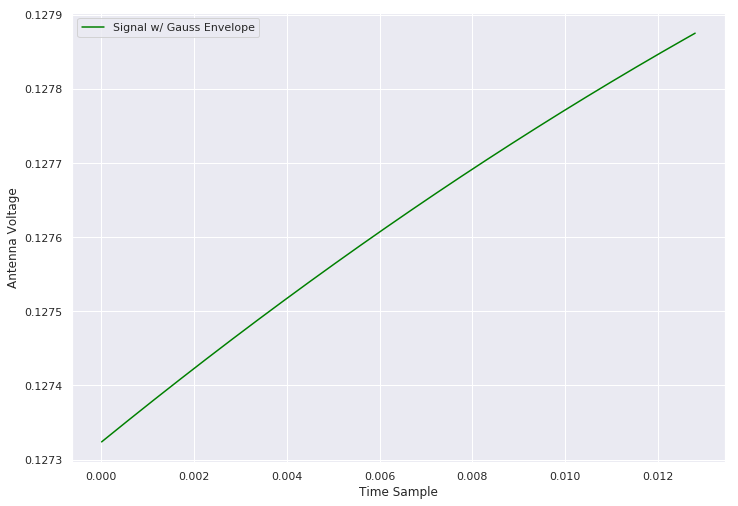

In [435]:
# Modulate the Chirp by a sinc function to emulate typical RSO Signatures
from scipy.signal import chirp,gausspulse,sweep_poly
TARGET_SNR = 20
NOISE_STD = 0.00173607422039 # experimentally derived standard deviation of the noise

noise_avg_watts = NOISE_STD**2
noise_avg_db = 10*np.log10(noise_avg_watts)

signal_avg_db = noise_avg_db + TARGET_SNR
sig_avg_watts = 10 ** (signal_avg_db / 10)

sig_avg_volts = np.sqrt(sig_avg_watts) # we can use this as amplitude for our chirp

x_volts = sig_avg_volts*chirp(t=ts, f0=f0, f1=f0, t1=step * t1)
noise_volts = np.random.normal(0, np.sqrt(noise_avg_watts), len(ts))

# Noise up the original signal
y_volts = x_volts + noise_volts

# Modulate the singal by a Gauss pulse
ds_span = 3000
signal_centre_f = f0 + ds_span/2.
# f_bw = signal_centre_f * 0.0000000005
r, gauss_envelope = gausspulse(ts, fc=1, bw=0.5, retenv=True, tpr=10)

ts1 = np.arange(start=-step * t1/2., stop=step * t1/2. - step, step=step)

r = (0.5 * np.sin(2.0*np.pi*100*ts1)) / ts1
r = np.sinc(ts1)

# p = np.poly1d([10, 5, 1.25, 2.0])

# w = sweep_poly(ts, p)

g_volts = x_volts * r

# Module the signal by a Sinc pulse
sinc_envelope = x_volts / ts
s_volts = x_volts * sinc_envelope
SAMPLES_TO_PLOT = 1000
# ax9 = sns.lineplot(y=noise_volts[:SAMPLES_TO_PLOT], x=ts[:SAMPLES_TO_PLOT], color='black', label='White Noise')
# ax9 = sns.lineplot(y=x_volts[:SAMPLES_TO_PLOT], x=ts[:SAMPLES_TO_PLOT], color='black', label='Clean Signal')
# ax9 = sns.lineplot(y=sinc_envelope[:SAMPLES_TO_PLOT], x=ts[:SAMPLES_TO_PLOT], color='red', label='Sinc Envelope')
# ax9 = sns.lineplot(y=gauss_envelope[:SAMPLES_TO_PLOT], x=ts[:SAMPLES_TO_PLOT], color='blue', label='Gauss Envelope')
ax9 = sns.lineplot(y=r[:SAMPLES_TO_PLOT], x=ts[:SAMPLES_TO_PLOT], color='green', label='Signal w/ Gauss Envelope')
# ax9 = sns.lineplot(y=g_volts[:SAMPLES_TO_PLOT], x=ts[:SAMPLES_TO_PLOT], color='orange', label='Signal w/ Envelope')

ax9.set(xlabel='Time Sample', ylabel='Antenna Voltage')
